In [119]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Embedding, Dropout, GlobalAveragePooling1D,LSTM,Bidirectional
from keras.utils import np_utils, to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

The below dataset, collected from Kaggle, contains stock prices of Google for a period of 5 years. This dataset has been used only for stock prediction using LSTM, since it does not contain any anomalies. 

Within the dataset only the opening and closing values of the stock price are considered as they are enough.

In [120]:
data = pd.read_csv('GOOG.csv')
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [121]:
print(data.shape)
data.info()

(1258, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [122]:
#Select only the opening and closing stock price values for future prediction.

#Convert date from string to datetime format

data = data[['date','open','close']]
data['date'] = pd.to_datetime(data['date'].apply(lambda x: x.split()[0]))
data.set_index('date',drop = True , inplace = True)

data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


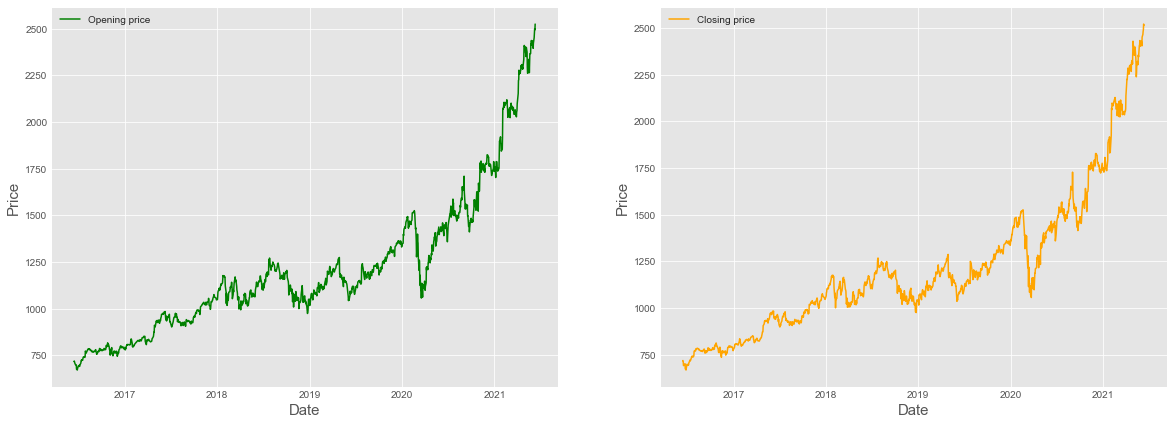

In [123]:
#Plot the opening and closing prices seperately.

fig, ax = plt.subplots(1, 2, figsize = (20 ,7))
ax[0].plot(data['open'],label='Opening price',color='green')
ax[0].set_xlabel('Date',size = 15)
ax[0].set_ylabel('Price',size = 15)
ax[0].legend()

ax[1].plot(data['close'],label='Closing price',color='orange')
ax[1].set_xlabel('Date',size = 15)
ax[1].set_ylabel('Price',size = 15)
ax[1].legend()


In [124]:
#Scale the price values using MinMaxScaler for easier processing

MMS = MinMaxScaler()      #From sklearn library

data[data.columns] = MMS.fit_transform(data)

In [125]:
data.head()

,open,close
date,,
2016-06-14,0.024532,0.026984
2016-06-15,0.025891,0.027334
2016-06-16,0.023685,0.022716
2016-06-17,0.020308,0.012658
2016-06-20,0.014979,0.013732


In [126]:
'''
Split the data into training and testing data.
We cannot use train_test_split(sklearn) here because it will select random values. 
We need the training data to be the first 80% of the values and the testing to be the next 20%.
This way, the prediction can be simplified and higher performance can be achieved.
'''
training_size = round(len(data)*0.80)      #To select the first 80% of the dataset

train_data = data[: training_size]
test_data = data[training_size: ]

train_data.shape , test_data.shape

((1006, 2), (252, 2))

In [127]:
'''
Create sequences of stock values and labels.
Labels in this case are stock prices after 50 time steps for training.
'''

def create_sequences(dataset):
    sequences = []
    labels = []
    
    start_idx = 0
    
    for stop_idx in range(50 , len(dataset)):
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
        
    return (np.array(sequences),np.array(labels))

In [128]:
train_seq , train_label = create_sequences(train_data)
test_seq , test_label = create_sequences(test_data)

In [129]:
train_seq.shape , train_label.shape

((956, 50, 2), (956, 2))

In [130]:
#Observe a single data point

print(train_seq[0])

[[0.0245318  0.02698372]
 [0.02589108 0.02733443]
 [0.02368495 0.02271575]
 [0.02030832 0.01265823]
 [0.01497907 0.01373196]
 [0.01477949 0.0149352 ]
 [0.0151355  0.01575534]
 [0.01426707 0.01813483]
 [0.00224929 0.00375538]
 [0.         0.        ]
 [0.004299   0.00635609]
 [0.00647277 0.00855213]
 [0.00780508 0.01286326]
 [0.01143523 0.01669958]
 [0.0135173  0.01415283]
 [0.01023777 0.0159226 ]
 [0.01460689 0.01462225]
 [0.01537283 0.0201636 ]
 [0.01998468 0.02526789]
 [0.02595581 0.02826249]
 [0.0283831  0.02628768]
 [0.02728273 0.02842975]
 [0.02952123 0.02783623]
 [0.02789225 0.03535239]
 [0.03176512 0.03706821]
 [0.03577824 0.03935058]
 [0.03741262 0.03796929]
 [0.03822171 0.04018691]
 [0.03757983 0.03858439]
 [0.03670061 0.03785598]
 [0.03629067 0.03966353]
 [0.04101579 0.04189733]
 [0.05486213 0.05424261]
 [0.04859433 0.05644944]
 [0.05269375 0.05547282]
 [0.05187926 0.05661131]
 [0.05459783 0.05576419]
 [0.05543929 0.06148899]
 [0.05987313 0.06124079]
 [0.05938768 0.0625897 ]


In [134]:
#Create an LSTM model for training. 

model = Sequential()

model.add(LSTM(units = 256,
              return_sequences = True,
              input_shape = (train_seq.shape[1],train_seq.shape[2])))
model.add(Dropout(0.25))
model.add(LSTM(units = 256))
model.add(Dense(2))

model.compile(loss = 'mean_squared_error',
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['mean_squared_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 256)           265216    
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 791,042
Trainable params: 791,042
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(train_seq , 
                    train_label , 
                    epochs = 10 , 
                    validation_data = (test_seq , test_label),
                    verbose=0)                                #Set verbose=0. We can visualize using plots.

In [136]:
test_predicted = model.predict(test_seq)            #Predictions
test_inverse = MMS.inverse_transform(test_predicted)  #Reverse scaling using MinMaxScaler

7/7 [==============================] - 3s 285ms/step


In [137]:
pred_data = pd.concat([data.iloc[-202:].copy(),pd.DataFrame(test_predicted,columns = ['open_predicted','close_predicted'],index = data.iloc[-202:].index)],axis=1)

In [138]:
pred_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,0.497853,0.496369,0.459015,0.449189
2020-08-25,0.491429,0.507171,0.462546,0.452433
2020-08-26,0.505416,0.530998,0.466513,0.456149
2020-08-27,0.530055,0.521259,0.471296,0.460613
2020-08-28,0.519165,0.526698,0.476702,0.465676


In [139]:
def metrics_curve(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['mean_squared_error']
    val_accuracy = history.history['val_mean_squared_error']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs , loss , label = 'Training Loss')
    plt.plot(epochs , val_loss , label = 'Validation Loss')            #Loss curve
    plt.title('Loss Curve of the model')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()

    plt.plot(epochs , accuracy , label = 'Mean squared error for training')
    plt.plot(epochs , val_accuracy , label = 'Mean sqaured error for validation')    #Mean squared error curve
    plt.title('Mean squared error Curve')
    plt.xlabel('Epochs')
    plt.legend()

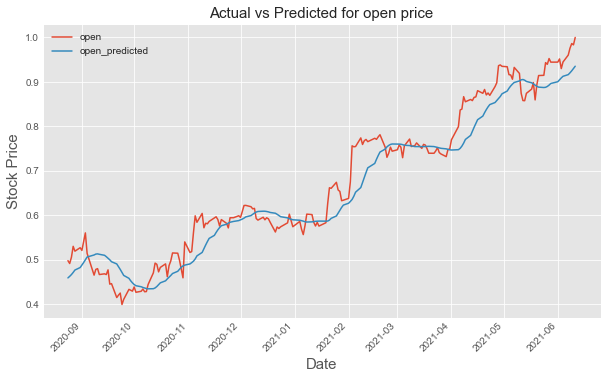

In [140]:
#Plot the predictions with actual values for comparison

pred_data[['open','open_predicted']].plot(figsize = (10,6))  
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

In [141]:
'''
In simple terms, anomalies are outliers. 
These outliers can be detected by using a threshold value and measuring their divergence from the central value.
However, as we can observe from the plotted graph of the values, we can say there are hardly any outliers.
We shall go through the calculations anyway.
'''

def detect_anomalies(time_series, threshold=np.percentile(data['open'],95)):
    # Calculate the mean and standard deviation of the time series
    mean = np.mean(time_series)
    std = np.std(time_series)

    # Calculate the Z-score for each data point
    z_scores = np.abs((time_series - mean) / std)

    # Find indices where Z-scores are above the threshold (potential anomalies)
    anomaly_indices = np.where(z_scores > threshold)[0]

    return anomaly_indices

# Example to show anomalies in the opening price of stock
time_series_data = data['open']
anomalies = detect_anomalies(time_series_data)

fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(data['open'] , label = 'Data' , color = 'blue')

#ax[1].scatter(anomalies , range(len(anomalies)) , label = 'Anomalies',color = 'red', marker='x')
plt.legend()

Since the above dataset does not have any anomalies, let us consider another dataset which has anomalies.
We shall break down each column of the dataset as an individual value and predict anomalies for each separately.
The main difference is that each point in the dataset is given a label on which whether it is an anomaly or not.

In [143]:
df = pd.read_csv('TimeSeries.csv')
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95


In [144]:
labels = pd.read_csv('labelsTimeSeries.csv')
labels.label.value_counts()

0    509189
1       443
Name: label, dtype: int64

In [145]:
df.isnull().values.any()

False

In [146]:
print(df.shape)
df.describe()

(509632, 11)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
count,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000
mean,-4.970240,-3.346117,1.932129,0.001911,0.002468,0.000450,42.773530,30.240553,-17.209860,-18.630128,28.974269
std,4.561687,6.118350,7.651674,0.215727,0.344642,0.172834,76.652202,64.720827,89.829919,19.805768,57.411149
min,-79.810000,-87.900000,-87.650000,-3.840000,-5.990000,-6.600000,-275.720000,-289.300000,-325.230000,-89.200000,-176.250000
25%,-8.860000,-5.050000,-1.200000,0.000000,0.000000,0.000000,7.120000,0.000000,-15.160000,-34.870000,-7.150000
50%,-2.750000,-3.090000,0.120000,0.000000,0.000000,0.000000,46.090000,15.860000,1.040000,-14.960000,-0.120000
75%,-1.090000,1.330000,9.480000,0.000000,0.010000,0.000000,60.340000,22.130000,11.440000,-8.130000,92.780000
max,78.900000,78.880000,76.830000,4.800000,5.830000,3.890000,306.760000,318.200000,323.020000,65.270000,179.430000


In [147]:
#Scale the values using StandardScaler(sklearn)

x = df.values

StdScaler = StandardScaler()
scaled_x = StdScaler.fit_transform(x)

data = pd.DataFrame(scaled_x , columns = df.columns)

data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,0.651128,0.793698,1.072691,-0.008859,-0.007162,-0.002601,-0.763887,-0.811958,0.061337,0.255488,1.114344
1,0.651128,0.793698,1.071384,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
2,0.651128,0.793698,1.071384,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
3,0.653320,0.793698,1.076611,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344
4,0.653320,0.793698,1.076611,-0.008859,-0.007162,-0.002601,-0.777976,-0.828491,0.076810,0.255488,1.114344


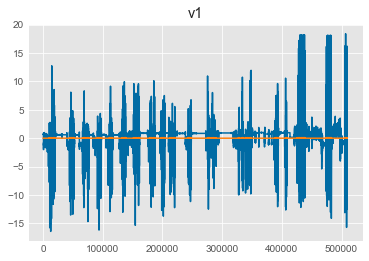

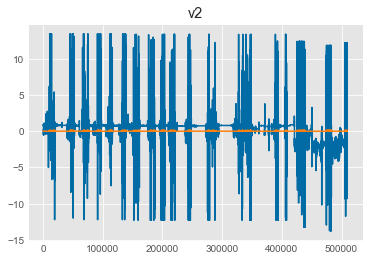

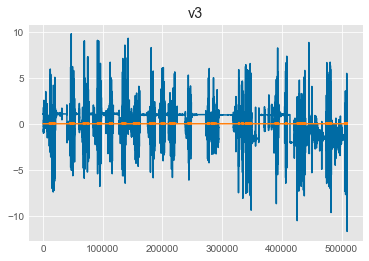

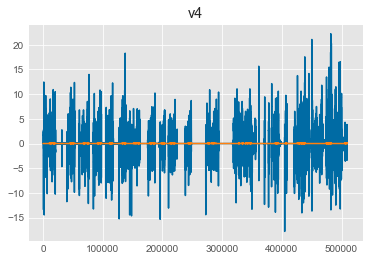

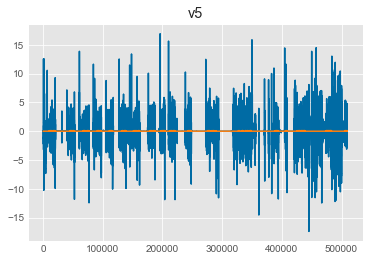

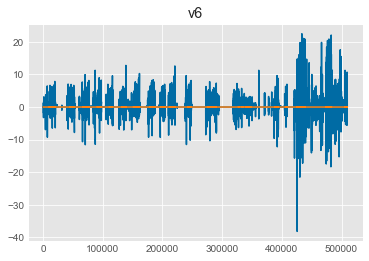

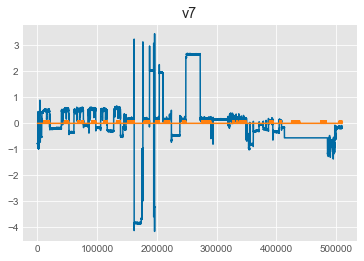

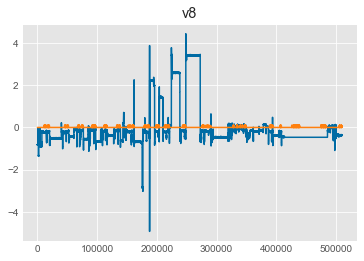

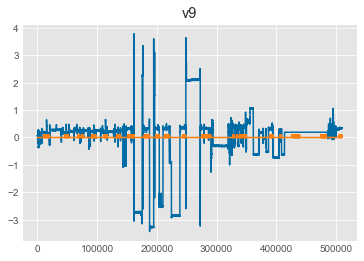

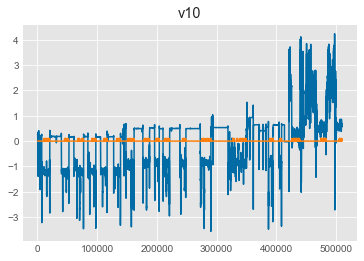

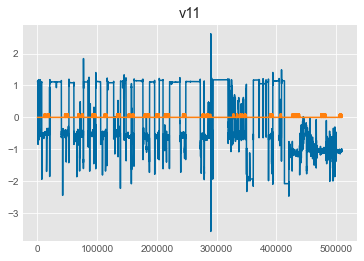

In [148]:
#Plot the values of every column in the scaled dataset

for col in data.columns:
    plt.style.use('tableau-colorblind10')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    
    x = np.linspace(0 , data.shape[0])
    ax.plot(data[col])
    ax.plot(labels['label']/10)

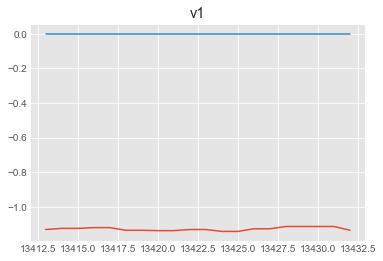

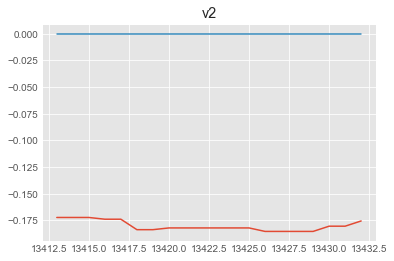

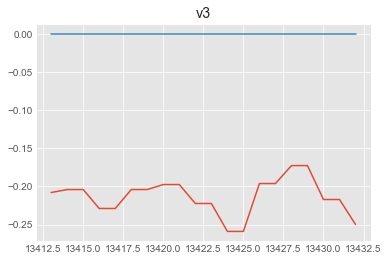

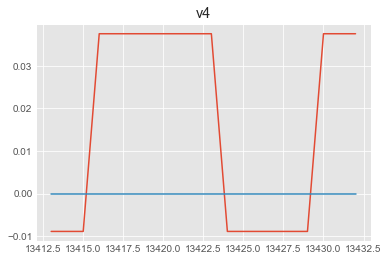

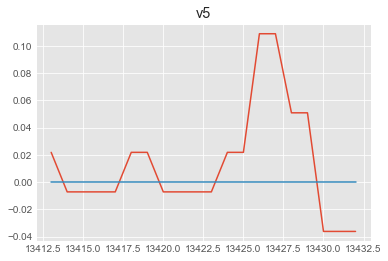

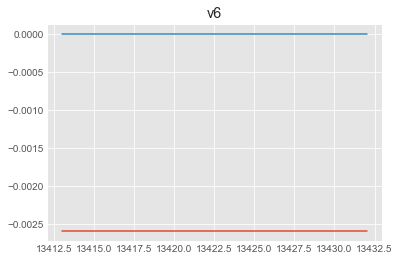

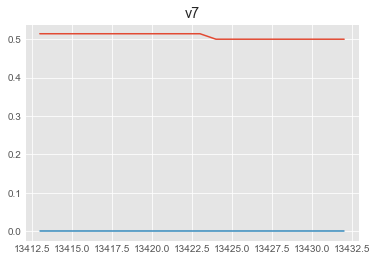

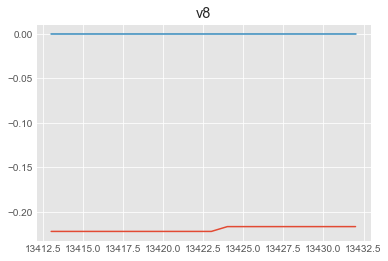

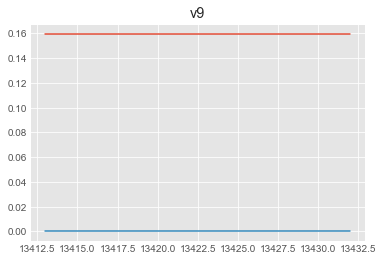

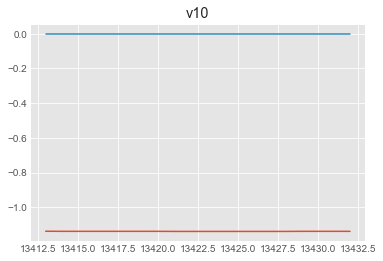

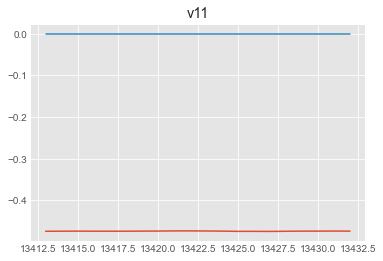

In [149]:
#Plot selected columns with labels

select_row = 13423

min_X = select_row - 10
max_X = select_row + 10

for col in data.columns:
    plt.style.use('ggplot')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    
    x = np.linspace(min_X , max_X)
    ax.plot(data[col][min_X:max_X])
    ax.plot(labels['label'][min_X:max_X])

In [150]:
#Separate the anomalies from the data points

data['label'] = labels['label']

no_anomaly = data[data['label']==0]
anomaly = data[data['label']==1]

print(no_anomaly.shape)
print(anomaly.shape)

(509189, 12)
(443, 12)


c:\users\anany\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 432x288 with 0 Axes>

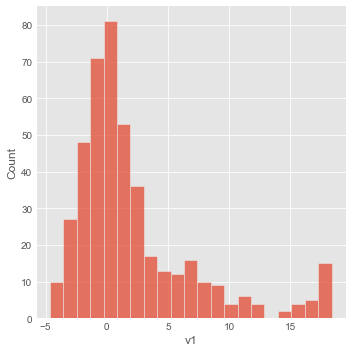

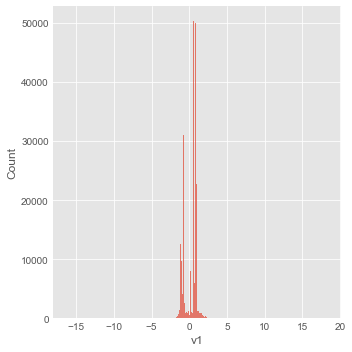

<Figure size 432x288 with 0 Axes>

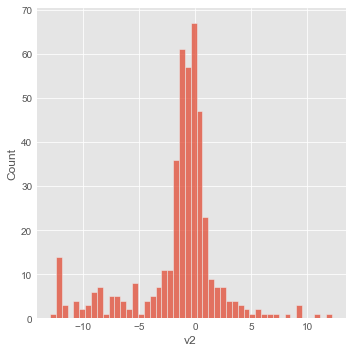

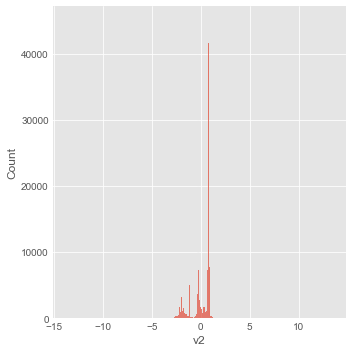

<Figure size 432x288 with 0 Axes>

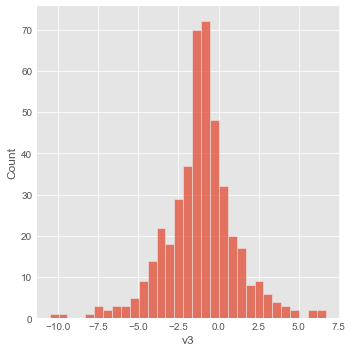

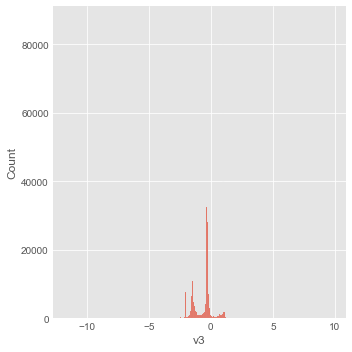

<Figure size 432x288 with 0 Axes>

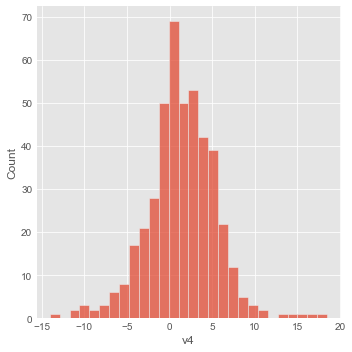

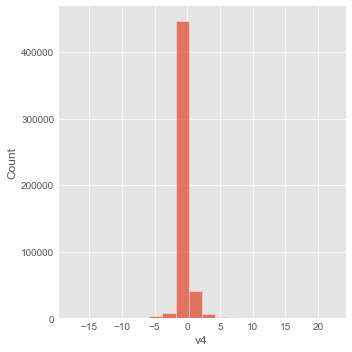

<Figure size 432x288 with 0 Axes>

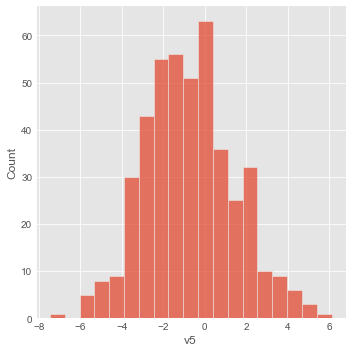

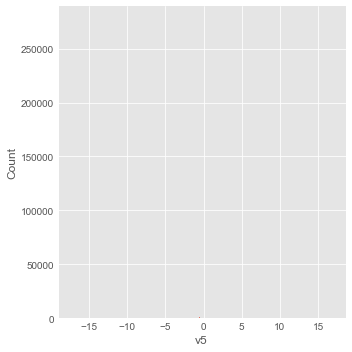

<Figure size 432x288 with 0 Axes>

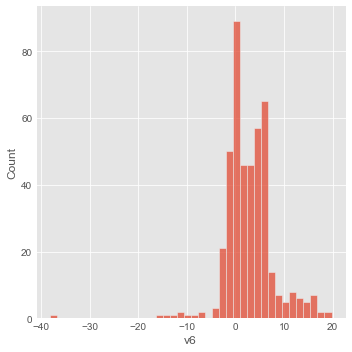

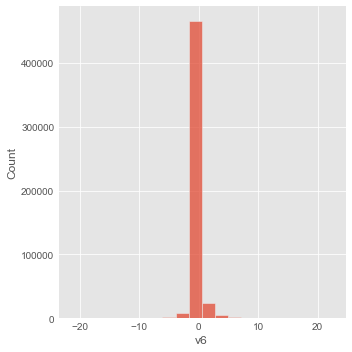

<Figure size 432x288 with 0 Axes>

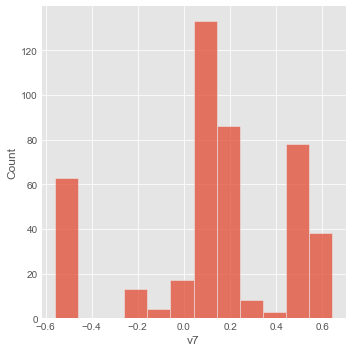

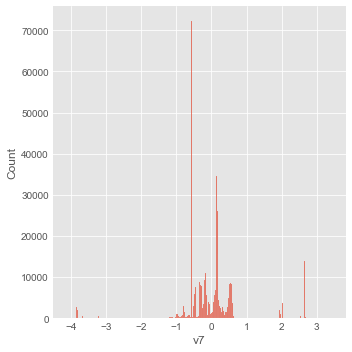

<Figure size 432x288 with 0 Axes>

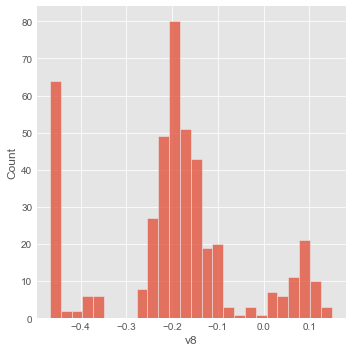

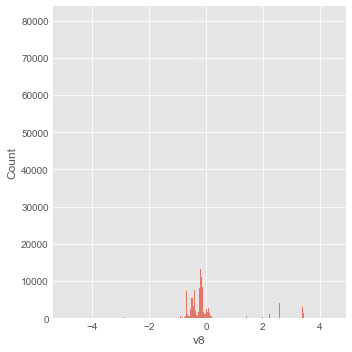

<Figure size 432x288 with 0 Axes>

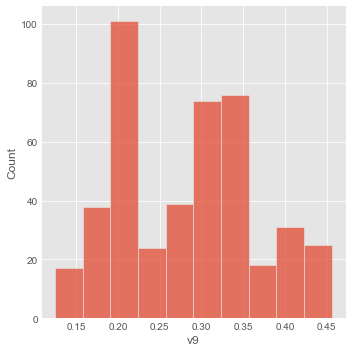

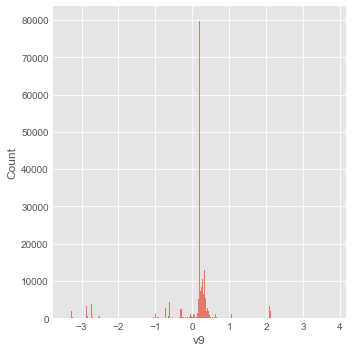

<Figure size 432x288 with 0 Axes>

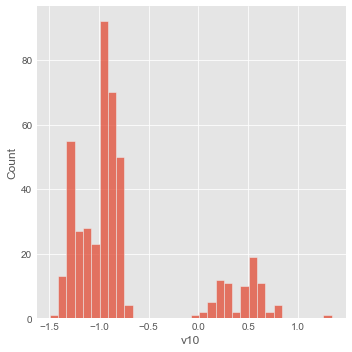

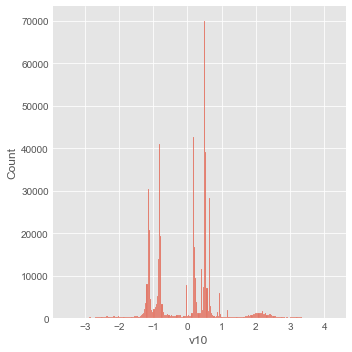

<Figure size 432x288 with 0 Axes>

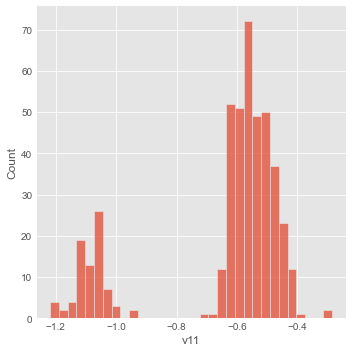

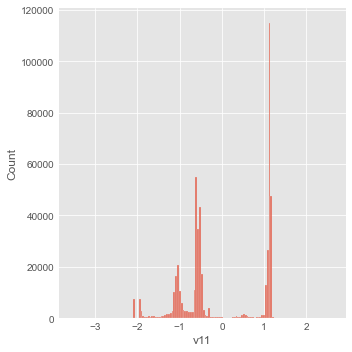

<Figure size 432x288 with 0 Axes>

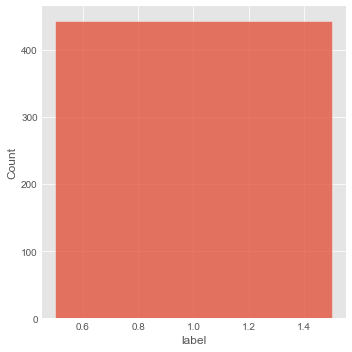

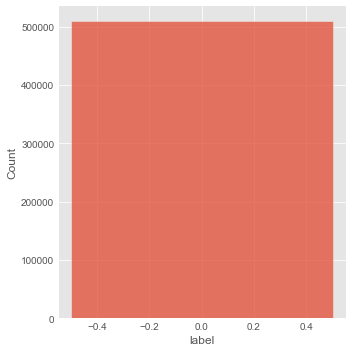

In [151]:
for col in data.columns:
    plt.figure()
    sns.displot(anomaly[col])
    sns.displot(no_anomaly[col])

In [152]:
cols = list(anomaly)[:-1]
anomaly = anomaly[cols]
no_anomaly = no_anomaly[cols]

print(no_anomaly.shape)
print(anomaly.shape)

(509189, 11)
(443, 11)


In [153]:
#Train and test split

test_data = 100000
shuffled_data = no_anomaly.sample(frac=1,random_state=42)[:-test_data].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-test_data:],anomaly[:]])
y_test = np.concatenate([np.zeros(test_data) , np.ones(anomaly.shape[0])])

print("X_train shape ", X_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape  (409189, 11)
X_test shape (100443, 11)
y_test shape (100443,)


In [154]:
# Identify the row where event
select_rows = data.index[data['label'] == 1]
len(select_rows)

443

In [155]:
#Define a function to find the minimum differnce between two data points

def min_difference(array, n):
    diff = 10*20
    
    for i in range(n-1):
        for j in range(i+1,n):
            if abs(array[i]-array[j]) < diff:
                diff = abs(array[i]-array[j])
                
    return diff

In [156]:
n = len(select_rows)
print(f'Minimum difference between the anomalies is {str(min_difference(select_rows , n))} time steps')

Minimum difference between the anomalies is 15 time steps


In [157]:
def chunk(seq , size):
    return (seq[pos:pos+size] for pos in range(0 , len(seq) , size))

In [158]:
#Create chunks of data for better handling

chunk_count = 0
result = []
chunk_size = 9

for df_chunk in chunk(data , chunk_size):
    if df_chunk.label.any() == 1 or df_chunk.shape[0] < chunk_size:
        pass
    else:
        result.append(df_chunk.iloc[:,:-1])
        chunk_count = chunk_count + 1 
        
chunk_count

56182

In [159]:
no_anomaly_arr = np.stack(result , axis=0)
no_anomaly_arr.shape

(56182, 9, 11)

In [160]:
index = data.index.get_indexer_for(data[data.label==1].index)
print(index.shape)

n = 4
data = data[cols]
anomaly_arr = data.iloc[np.unique(np.concatenate([np.arange(max(i-n,0) , min(i+n+1 , len(data))) for i in index]))]

pd.options.display.max_rows = 100
anomaly_arr.head(5)

(443,)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
10698,-0.688290,0.135023,-0.181938,-0.008859,-0.007162,0.055258,0.492700,-0.224975,0.177111,-1.138047,-0.511474
10699,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.158748,-0.519835
10700,-6.657578,1.570052,-2.427201,2.216179,1.356574,1.386014,0.497396,-0.247224,0.161749,-1.178944,-0.528369
10701,-7.762434,6.190583,-2.263837,-2.790157,-1.748101,0.749565,0.497396,-0.247224,0.161749,-1.209743,-0.526453
10702,-0.914084,0.257605,-1.712324,6.202706,-1.167788,4.799691,0.497396,-0.247224,0.161749,-1.240038,-0.523492


In [161]:
ChunkCounter = 0
result_arrList = []
chunkSize = 9

for df_chunk in chunk(anomaly_arr, chunkSize):
    if df_chunk.shape[0] < chunkSize:
        pass
    else:
        result_arrList.append(df_chunk)
        ChunkCounter = ChunkCounter + 1
        #print(df_chunk)
    
ChunkCounter

443

In [162]:
anomaly_arr = np.stack(result_arrList , axis=0)
anomaly_arr.shape

(443, 9, 11)

In [163]:
final_array = np.append(no_anomaly_arr , anomaly_arr , axis=0)
final_array.shape

(56625, 9, 11)

In [164]:
y_zeros = np.zeros(no_anomaly_arr.shape[0])

y_ones = np.ones(anomaly_arr.shape[0])

y = np.append(y_zeros,y_ones,axis=0)

y.shape

(56625,)

In [165]:
X_train,X_test,y_train,y_test = train_test_split(final_array,y,test_size=0.2,random_state = 42)
print ('X_train shape: ', X_train.shape)
print ('X_test shape: ', X_test.shape)
print ('y_train shape: ', y_train.shape)
print ('y_test shape: ', y_test.shape)

X_train shape:  (45300, 9, 11)
X_test shape:  (11325, 9, 11)
y_train shape:  (45300,)
y_test shape:  (11325,)


In [166]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_train.shape)
print(X_test.shape)

(45300, 9, 11, 1)
(11325, 9, 11, 1)


In [167]:
#Generate a function for obtaining f1-score of the predictions since there is no existing library function

import keras.backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [168]:
# Convolutional neural network for training the dataset

n_filters = 64
fsize = 5 
window_size = 9   # Number of time steps in one period
n_features = 11


model = models.Sequential()

model.add(layers.Conv2D(n_filters, fsize, activation='relu', input_shape=(window_size, n_features, 1)))
model.add(layers.Conv2D(n_filters, fsize, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=[get_f1])
              
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 5, 7, 64)          1664      
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 3, 64)          102464    
                                                                 
 flatten_2 (Flatten)         (None, 192)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               49408     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 153,793
Trainable params: 153,793
Non-trainable params: 0
_________________________________________________________________
None


In [169]:
history = model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs = 20,
                   batch_size = 16)

Epoch 1/20
2265/2265 [==============================] - 14s 6ms/step - loss: 0.0271 - get_f1: 0.0737 - val_loss: 0.0039 - val_get_f1: 0.1070
Epoch 2/20
2265/2265 [==============================] - 14s 6ms/step - loss: 0.0031 - get_f1: 0.1083 - val_loss: 0.0028 - val_get_f1: 0.1093
Epoch 3/20
2265/2265 [==============================] - 13s 6ms/step - loss: 0.0016 - get_f1: 0.1147 - val_loss: 0.0018 - val_get_f1: 0.1105
Epoch 4/20
2265/2265 [==============================] - 15s 6ms/step - loss: 0.0010 - get_f1: 0.1177 - val_loss: 0.0021 - val_get_f1: 0.1105
Epoch 5/20
2265/2265 [==============================] - 14s 6ms/step - loss: 0.0010 - get_f1: 0.1165 - val_loss: 0.0028 - val_get_f1: 0.1105
Epoch 6/20
2265/2265 [==============================] - 19s 8ms/step - loss: 4.3623e-04 - get_f1: 0.1136 - val_loss: 0.0027 - val_get_f1: 0.1123
Epoch 7/20
2265/2265 [==============================] - 11s 5ms/step - loss: 7.6868e-04 - get_f1: 0.1219 - val_loss: 0.0030 - val_get_f1: 0.1129
Epoch

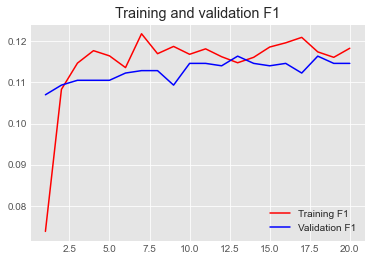

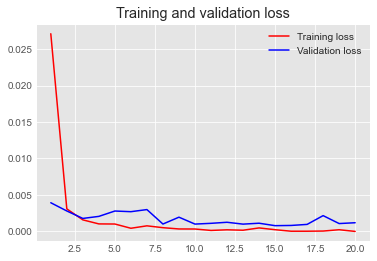

In [170]:
acc = history.history['get_f1'] 
val_acc = history.history['val_get_f1'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'r', label='Training F1') 
plt.plot(epochs, val_acc, 'b', label='Validation F1') 
plt.title('Training and validation F1') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'r', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()

In [171]:
preds = model.predict(X_test)
preds.shape

354/354 [==============================] - 1s 2ms/step


(11325, 1)

In [172]:
#Divide the predictions into an array of binary values

preds[np.where(preds >= 0.5)] = 1
preds[np.where(preds < 0.5)] = 0

preds.shape

(11325, 1)

In [173]:
from sklearn import metrics
conf_mx = metrics.confusion_matrix(y_test, preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  11230
FP:  3
FN:  3
TP:  89
0.967391304347826 0.967391304347826


In [174]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

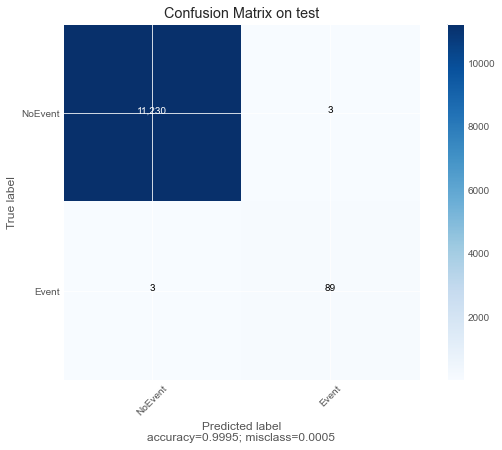

In [175]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['NoEvent', 'Event'],
                      title        = "Confusion Matrix on test")